# Install Python packages

In [ ]:
!pip install python-terrier repro_eval==0.4 tqdm pandas seaborn matplotlib
!wget https://ir.nist.gov/trec-covid/data/qrels-covid_d5_j0.5-5.txt
qrels = 'qrels-covid_d5_j0.5-5.txt'

# Imports

In [ ]:
import os
import collections
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import pyterrier as pt
from repro_eval.Evaluator import RpdEvaluator
from repro_eval.util import trim

# Define helper functions

In [ ]:
def parse_run(f_run):
    run = collections.defaultdict(dict)
    for line in f_run:
        query_id, _, object_id, ranking, score, _ = line.strip().split()
        run[query_id][object_id] = float(score)

    return run

def parse_qrels(f_qrels):
    qrels = collections.defaultdict(dict)
    for line in f_qrels:
        query_id, _, object_id, relevance = line.strip().split()
        qrels[query_id][object_id] = int(relevance)

    return qrels

# Make directories for results and figures

In [ ]:
import os

dirs = ['runs', 'results', 'figures']
for dir in dirs:
  os.makedirs(dir, exist_ok=True)

# Build the search index

In [ ]:
if not pt.started():
  pt.init()

dataset = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './indices/cord19'

if not os.path.exists(pt_index_path + "/data.properties"):
      indexer = pt.index.IterDictIndexer(pt_index_path, blocks=True)
      index_ref = indexer.index(dataset.get_corpus_iter(),
                                fields=['title', 'doi', 'date', 'abstract'],
                                meta=('docno',))
else:
    index_ref = pt.IndexRef.of(pt_index_path + "/data.properties")

index = pt.IndexFactory.of(index_ref)

# Retrieve the rankings and write them to files

In [ ]:
# lores version
# C = [round(0.2 + 0.05 * i, 3) for i in range(0,13)]
# K1 = [round(0.5 + 0.05 * i, 3) for i in range(0,13)]

# hires version
C = [round(0.2 + 0.0125 * i, 4) for i in range(0,49)]
K1 = [round(0.5 + 0.0125 * i, 4) for i in range(0,49)]

T = 20

_total = len(C)*len(K1)

with tqdm(total=_total, position=0, leave=True) as pbar:
  for _c in C:
    for _k1 in K1:
      bm25 = pt.BatchRetrieve(index , wmodel='BM25', controls={"c" : _c, "bm25.k_1": _k1, "bm25.k_3": 0.75}, num_results=T)
      res = bm25.transform(dataset.get_topics('title'))
      run_name = '_'.join(['runs/bm25', str(_c), str(_k1)])
      file_name = '.'.join([run_name, 'txt'])
      pt.io.write_results(res, file_name, format='trec',run_name=run_name)
      pbar.update()

# Evaluate the rank correlation

In [ ]:
_t = 10
reference = (0.5, 0.8)
reference_run_name = '_'.join(['runs/bm25', str(reference[0]), str(reference[1])])
reference_file_name = '.'.join([reference_run_name, 'txt'])

rpd_eval = RpdEvaluator(qrel_orig_path=qrels)

with open(reference_file_name) as f_in:
  run_b_orig = parse_run(f_in)

rpd_eval.run_b_orig = run_b_orig
rpd_eval.trim(_t)
rpd_eval.evaluate()

ktu = {}

with tqdm(total=_total, position=0, leave=True) as pbar:
  for _c in C:
    for _k1 in K1:
      run_name = '_'.join(['runs/bm25', str(_c), str(_k1)])
      file_name = '.'.join([run_name, 'txt'])
      with open(file_name) as f_in:
        _run = parse_run(f_in)
        trim(_run, _t)
        ktu[(_c,_k1)] = sum(rpd_eval.ktau_union(run_b_rep=_run).get('baseline').values()) / 50
        pbar.update()

df_data_ktu = {}
for _c in C:
  _data_ktu = {}
  for _k1 in K1:
    _data_ktu[_k1] = ktu.get((_c,_k1))
  df_data_ktu[_c] = _data_ktu


# Plot the rank correlation

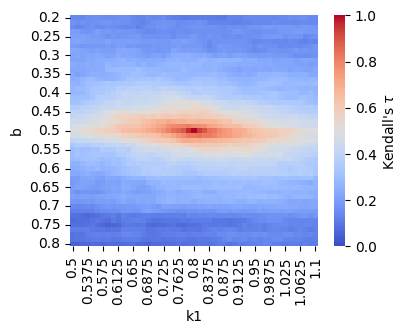

In [ ]:
CMAP = 'coolwarm'
df_ktu = pd.DataFrame.from_dict(df_data_ktu).transpose()
df_ktu.to_csv('results/ktu' + '_' + str(_t) + '.csv')
plt.figure(figsize=(4,3))
sns.heatmap(df_ktu, cmap=CMAP, cbar_kws={'label': r"Kendall's $\tau$"}, vmin=.0, vmax=1.)
plt.ylabel("b")
plt.xlabel("k1")
plt.savefig('figures/ktu' + '_' + str(_t) + '.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Evaluate the error between the effectiveness scores

In [ ]:
_t = 10
reference = (0.5, 0.8)
reference_run_name = '_'.join(['runs/bm25', str(reference[0]), str(reference[1])])
reference_file_name = '.'.join([reference_run_name, 'txt'])

rpd_eval = RpdEvaluator(qrel_orig_path=qrels)

with open(reference_file_name) as f_in:
  run_b_orig = parse_run(f_in)

rpd_eval.run_b_orig = run_b_orig
rpd_eval.trim(_t)
rpd_eval.evaluate()

rmse = {}

with tqdm(total=_total, position=0, leave=True) as pbar:
  for _c in C:
    for _k1 in K1:
      run_name = '_'.join(['runs/bm25', str(_c), str(_k1)])
      file_name = '.'.join([run_name, 'txt'])
      with open(file_name) as f_in:
        _run = parse_run(f_in)
        _rpd_eval = RpdEvaluator(qrel_orig_path=qrels)
        _rpd_eval.run_b_orig = _run
        _rpd_eval.trim(_t)
        _rpd_eval.evaluate()
        rmse[(_c,_k1)] = rpd_eval.rmse(run_b_score=_rpd_eval.run_b_orig_score).get('baseline').get('P_10')
        pbar.update()

df_data_rmse = {}
for _c in C:
  _data_rmse = {}
  for _k1 in K1:
    _data_rmse[_k1] = rmse.get((_c,_k1))
  df_data_rmse[_c] = _data_rmse

# Plot the error between the effectiveness scores

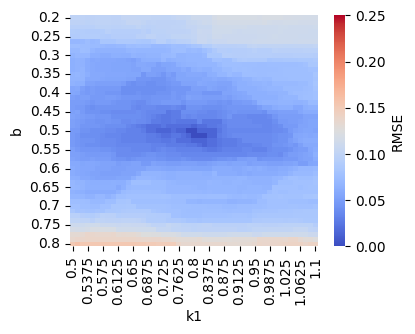

In [ ]:
CMAP = 'coolwarm'
df_rmse = pd.DataFrame.from_dict(df_data_rmse).transpose()
df_rmse.to_csv('results/rmse' + '_' + str(_t) + '.csv')
plt.figure(figsize=(4,3))
sns.heatmap(df_rmse, cmap=CMAP, cbar_kws={'label': 'RMSE'}, vmin=0.0, vmax=0.25)
plt.ylabel("b")
plt.xlabel("k1")
plt.savefig('figures/rmse' + '_' + str(_t) + '.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Evaluate the average retrieval effectiveness

In [ ]:
_t = 10
p10 = {}

with tqdm(total=_total, position=0, leave=True) as pbar:
  for _c in C:
    for _k1 in K1:
      run_name = '_'.join(['runs/bm25', str(_c), str(_k1)])
      file_name = '.'.join([run_name, 'txt'])
      with open(file_name) as f_in:
        _run = parse_run(f_in)
        rpd_eval.run_b_orig = _run
        rpd_eval.trim(_t)
        rpd_eval.evaluate()
        p10[(_c,_k1)] = sum([t.get('P_10') for t in rpd_eval.run_b_orig_score.values()]) / 50
        pbar.update()

df_data_p10 = {}
for _c in C:
  _data_p10 = {}
  for _k1 in K1:
    _data_p10[_k1] = p10.get((_c,_k1))
  df_data_p10[_c] = _data_p10

# Plot the average retrieval effectiveness

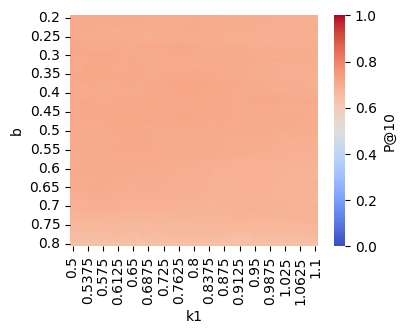

In [ ]:
CMAP = 'coolwarm'
df_p10 = pd.DataFrame.from_dict(df_data_p10).transpose()
df_p10.to_csv('results/p' + '_' + str(_t) + '.csv')
plt.figure(figsize=(4,3))
sns.heatmap(df_p10, cmap=CMAP, cbar_kws={'label': 'P@10'}, vmin=.0, vmax=1.)
plt.ylabel("b")
plt.xlabel("k1")
plt.savefig('figures/p' + '_' + str(_t) + '.pdf', format='pdf', bbox_inches='tight')
plt.show()